<h1>oSLRAU on Synthetic HMM data</h1>

We fit a hmm and then see if an rspn trained with oSLRAU can match the log likelihood on given data

In [1]:
from oSLRAU_run import get_data
from spn.structure.leaves.parametric.Parametric import Gaussian, In_Latent
from spn.structure.Base import Context
from spn.algorithms.LearningWrappers import learn_parametric
from spn.io.Graphics import plot_spn
import numpy as np
from spn.algorithms.Inference import log_likelihood
from sklearn.model_selection import train_test_split
from spn.algorithms.oSLRAU import oSLRAU, oSLRAUParams
from spn.algorithms.RSPN import RSPN
from spn.algorithms.TransformStructure import Prune ,Prune_oSLRAU

from hmmlearn import hmm
from spn.algorithms.Inference import log_likelihood

We use a hmm with 3 latent variables and univariate gaussian emissions

In [2]:
# Set the mean and standard deviation of the Gaussian distribution
mean0 = 0.0 
std0 = 1.0  

mean1 = 10.0 
std1 = 1.0  

mean2 = 20.0
std2 = 1.0  


# Generate random samples from the Gaussian distribution
num_samples=1000

gen_data = [eval(f"np.random.normal(mean{i%3}, std{i%3})") for i in range(num_samples)]


print(gen_data[:6])

[1.6321075100119946, 11.833194123909742, 20.621634450501663, -2.643332397955323, 9.467062044363194, 19.960974685908443]


In [4]:
n_states = 3  # Number of hidden states
model = hmm.GaussianHMM(n_components=n_states)

In [5]:
# Reshape the observations into a 2D array (required by hmmlearn)
X = np.array(gen_data).reshape(-1, 1)

# Fit the model to the data
model.fit(X)

GaussianHMM(n_components=3)

We print the parameters of the hmm:

In [6]:
# Transition matrix
transition_matrix = model.transmat_
print("Transition Matrix:")
print(transition_matrix)

# Mean values for each state
means = model.means_
print("State Means:")
print(means)

# Covariance matrices for each state
covars = model.covars_
print("State Covariances:")
print(covars)


Transition Matrix:
[[4.27147325e-131 1.00000000e+000 1.10403710e-117]
 [4.29233427e-103 3.21247557e-080 1.00000000e+000]
 [1.00000000e+000 8.12782079e-069 8.12782079e-069]]
State Means:
[[ 9.95656084]
 [19.88644815]
 [ 0.05562649]]
State Covariances:
[[[1.00784125]]

 [[1.10029463]]

 [[1.07223592]]]


In [7]:
# Function that calculates the average log likelihood of the given sequences
def hmm_avg_ll(hmm_model, data_seq):
    log_likelihoods = []

    for sequence in data_seq:
        log_likelihood = hmm_model.score(sequence)
        log_likelihoods.append(log_likelihood)

    return np.mean(log_likelihoods)

<h2> Code to train RSPN</h2>

In [7]:
def train_rspn(train_data, test_data, rspn=None):

    if len(train_data.shape) == 3: train_data = np.squeeze(train_data)
    if len(test_data.shape) == 3: test_data = np.squeeze(test_data)

    if rspn is None:
    
        rspn = RSPN(num_variables=num_variables, num_latent_variables=num_latent_variables, num_latent_values=num_latent_values)
        first_mini_batch = train_data[0:mini_batch_size]
        n = first_mini_batch.shape[1]
        print(n)
        context = [Gaussian] * n
        ds_context = Context(parametric_types=context).add_domains(first_mini_batch[:, :num_variables])
        spn, initial_template_spn, top_spn = rspn.build_initial_template(first_mini_batch, ds_context, len_sequence_varies)

    
    no_of_minibatches = int(train_data.shape[0] / mini_batch_size)

    print(f"no of minibatches: {no_of_minibatches}")

    
    for i in range(1, no_of_minibatches):
        mini_batch = train_data[i * mini_batch_size: (i+1) * mini_batch_size]
    
        update_template = False
        
        if i % update_after_no_min_batches == 0:
            print(i)
            update_template = True
    
        template_spn = rspn.learn_rspn(mini_batch, update_template, oSLRAU_params, unroll, full_update, update_leaves,
                                       len_sequence_varies)
           
            
    test_ll = np.mean(rspn.log_likelihood(test_data, unroll, len_sequence_varies))


    return test_ll, rspn, template_spn

avg_ll takes data, splits it, and then trains and extracts the log likelihood

In [1]:
def avg_ll(data, num_epochs=1, do_plot_spn=True):
    ll_list = []
    rspn=None
    train_data, val_data= train_test_split(data, test_size=0.1, random_state=42)
    for i in range(num_epochs):

        
        epoch_ll, rspn, template_spn = train_rspn(train_data, val_data, rspn)        
        print(f"epoch_ll: {epoch_ll}")
        
        ll_list.append(epoch_ll)

    average_ll = np.mean(np.array(ll_list))
    print(f" \n\n\n average ll: {average_ll}\n\n\n")

    if do_plot_spn:
        plot_spn(template_spn, 'rspn_final_template.pdf')
    
    return rspn

In [190]:
def final_ll(data, num_epochs=1, do_plot_spn=True):
    final_test_ll = 0
    rspn=None
    train_data, val_data= train_test_split(data, test_size=0.1, random_state=42)
    for i in range(num_epochs):
        final_test_ll, rspn, template_spn = train_rspn(train_data, val_data, rspn)        
        print(f"final_test_ll epoch {i+1}/{num_epochs}: {final_test_ll}")

    if do_plot_spn:
        plot_spn(template_spn, 'rspn_final_template.pdf')
    
    return rspn
    

In [140]:
#data to be used for training and validation of rspn
num_time_steps = 30
num_seq = 40
rspn_data = np.array([model.sample(num_time_steps)[0] for _ in range(num_seq)])

In [50]:
num_variables = num_time_steps
num_latent_variables = 3
num_latent_values = 3
unroll = 'backward'
full_update = False
update_leaves = True
len_sequence_varies = False
oSLRAU_params = oSLRAUParams(mergebatch_threshold=10, corrthresh=0.7, mvmaxscope=1, equalweight=True, currVals=True)


mini_batch_size = 3
update_after_no_min_batches = 2

Now we train the rspn network:

30
Building initial spn
Building initial template spn
Building top spn
no of minibatches: 12
2
Updating template spn
4
Updating template spn
6
Updating template spn
8
Updating template spn
10
Updating template spn
Length of the sequence in mini_batch: 1
Evaluating rspn bottom up
epoch_ll: -41.24726785234653
 


 average ll: -41.24726785234653





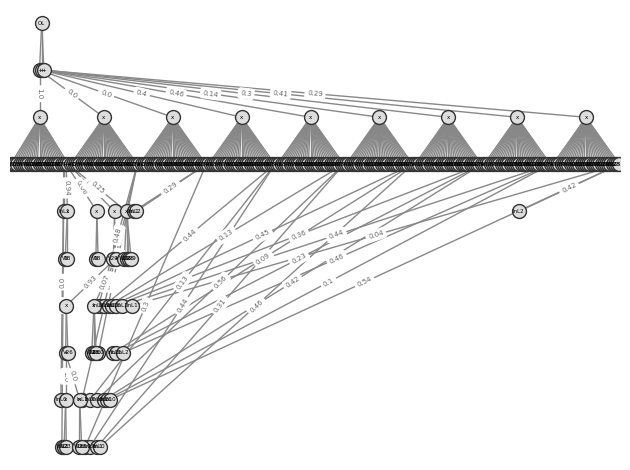

In [51]:
rspn = avg_ll(rspn_data)

Now we test our rspn and the hmm on some test data to see their respective log likelihoods

In [70]:
test_len = 10
test_data = np.array([model.sample(num_time_steps)[0] for _ in range(test_len)])

In [71]:
hmm_test_ll = hmm_avg_ll(model, test_data)
hmm_test_ll

-41.285297312686815

In [72]:
if len(test_data.shape) == 3: test_data = np.squeeze(test_data)
rspn_test_ll = np.mean(rspn.log_likelihood(test_data, unroll, len_sequence_varies))
rspn_test_ll

Length of the sequence in mini_batch: 1
Evaluating rspn bottom up


-42.03891745138844

Hence as we can see, the rspn and the hmm have very similar log likelihoods

<h1>More complicted example</h1>

We have 10 latent variables with a random transition matrix and means closer together

In [176]:
n_states = 10
model2 = hmm.GaussianHMM(n_components=n_states)
model2.fit(X)

transition_matrix2 = np.random.rand(n_states, n_states)
trans2_sum = np.sum(transition_matrix2, axis=1)
trans2_sum = trans2_sum[:, np.newaxis]
transition_matrix2 = transition_matrix2 / trans2_sum

model2.transmat_ = transition_matrix2



model2.means_ = np.array([[float(i)] for i in range(n_states)])


model2.covars_ = np.array([[1.0] for _ in range(n_states)])

print(transition_matrix2)


[[0.00749252 0.0651102  0.03460501 0.17586182 0.15808956 0.12556702
  0.12123975 0.12356709 0.11852976 0.06993727]
 [0.1068191  0.10563922 0.03812469 0.0851551  0.00608596 0.19584482
  0.08118206 0.06490203 0.20514258 0.11110444]
 [0.13047991 0.10981136 0.0107968  0.21286083 0.15140619 0.01270162
  0.00651861 0.19493568 0.1702715  0.0002175 ]
 [0.18754242 0.08173445 0.10757737 0.03148777 0.06388511 0.04091736
  0.14383864 0.04577156 0.1872533  0.10999201]
 [0.20015097 0.09622186 0.13953069 0.1932709  0.02667019 0.00844498
  0.09142117 0.11232006 0.11978076 0.01218842]
 [0.09117709 0.08097686 0.12191136 0.0850016  0.11388286 0.13730199
  0.12785895 0.06745663 0.14195188 0.03248078]
 [0.12175066 0.09970354 0.01246314 0.17900239 0.13584252 0.16846377
  0.03015599 0.1339653  0.07856232 0.04009038]
 [0.02904306 0.18634205 0.16574086 0.15652615 0.02355531 0.00139282
  0.0069677  0.12266781 0.17935174 0.1284125 ]
 [0.10926961 0.09773334 0.01569444 0.13321571 0.0623928  0.15557631
  0.13116602

In [186]:
#data to be used for training and validation of rspn
num_time_steps = 30
num_seq = 100
rspn_data2 = np.array([model2.sample(num_time_steps)[0] for _ in range(num_seq)])

In [187]:
num_variables = num_time_steps
num_latent_variables = n_states
num_latent_values = n_states
unroll = 'backward'
full_update = False
update_leaves = True
len_sequence_varies = False
oSLRAU_params = oSLRAUParams(mergebatch_threshold=10, corrthresh=0.7, mvmaxscope=1, equalweight=True, currVals=True)


mini_batch_size = 8
update_after_no_min_batches = 2

In [188]:
rspn2 = avg_ll(rspn_data2, do_plot_spn=False)

30
Building initial spn
Building initial template spn
Building top spn
no of minibatches: 11
2
Updating template spn
4
Updating template spn
6
Updating template spn
8
Updating template spn
10
Updating template spn
Length of the sequence in mini_batch: 1
Evaluating rspn bottom up
epoch_ll: -73.67548913600744
 


 average ll: -73.67548913600744





In [183]:
test_len = 50
test_data2 = np.array([model2.sample(num_time_steps)[0] for _ in range(test_len)])

In [184]:
hmm_test_ll2 = hmm_avg_ll(model2, test_data2)
hmm_test_ll2

-72.89266841829844

In [185]:
if len(test_data2.shape) == 3: test_data2 = np.squeeze(test_data2)
rspn_test_ll2 = np.mean(rspn2.log_likelihood(test_data2, unroll, len_sequence_varies))
rspn_test_ll2

Length of the sequence in mini_batch: 1
Evaluating rspn bottom up


-74.99058918292071

Again, the log likelihoods are close to each other

<h1> On Multivariate normal data </h1> 

In [11]:
from oSLRAU_run import get_data
from spn.structure.leaves.parametric.Parametric import Gaussian, In_Latent
from spn.structure.Base import Context
from spn.algorithms.LearningWrappers import learn_parametric
from spn.io.Graphics import plot_spn
import numpy as np
from spn.algorithms.Inference import log_likelihood
from sklearn.model_selection import train_test_split
from spn.algorithms.oSLRAU import oSLRAU, oSLRAUParams
from spn.algorithms.RSPN import RSPN
from spn.algorithms.TransformStructure import Prune ,Prune_oSLRAU

from hmmlearn import hmm
from spn.algorithms.Inference import log_likelihood

In [12]:
# Define the number of hidden states
n_states = 3
n_dim = 2

# Define the transition matrix
transmat = np.array([[0.7, 0.2, 0.1],
                     [0.3, 0.5, 0.2],
                     [0.1, 0.3, 0.6]])

# Define the initial state probabilities
startprob = np.array([0.6, 0.3, 0.1])

# Define the Multivariate Gaussian emission distributions
means = np.array([[0.0, 0.0], [1.0, 2.0], [2.0, 3.0]])
covars = np.tile(np.identity(2), (n_states, 1, 1))  # Use identity matrix as the covariance for simplicity

# Create the Multivariate Gaussian HMM model
model_mvn = hmm.GaussianHMM(n_components=n_states, covariance_type="full")
model_mvn.startprob_ = startprob
model_mvn.transmat_ = transmat
model_mvn.means_ = means
model_mvn.covars_ = covars

In [14]:
num_time_steps_mvn = 5
num_seq_mvn = 100
rspn_data_mvn= np.array([model_mvn.sample(num_time_steps_mvn)[0] for _ in range(num_seq_mvn)])
print(f"==>> rspn_data_mvn.shape: {rspn_data_mvn.shape}")
rspn_data_mvn = rspn_data_mvn.reshape((rspn_data_mvn.shape[0], -1))
print(f"==>> rspn_data_mvn.shape: {rspn_data_mvn.shape}")



==>> rspn_data_mvn.shape: (100, 5, 2)
==>> rspn_data_mvn.shape: (100, 10)


In [16]:
num_variables = num_time_steps_mvn * n_dim
num_latent_variables = 3
num_latent_values = 2
unroll = 'backward'
full_update = False
update_leaves = True
len_sequence_varies = False
oSLRAU_params = oSLRAUParams(mergebatch_threshold=10, corrthresh=0.7, mvmaxscope=1, equalweight=True, currVals=True)


mini_batch_size = 3
update_after_no_min_batches = 2

In [17]:
def train_rspn_mvn(train_data, test_data, rspn=None):

    if len(train_data.shape) == 3: train_data = np.squeeze(train_data)
    if len(test_data.shape) == 3: test_data = np.squeeze(test_data)

    if rspn is None:
    
        rspn = RSPN(num_variables=num_variables, num_latent_variables=num_latent_variables, num_latent_values=num_latent_values)
        first_mini_batch = train_data[0:mini_batch_size]
        n = first_mini_batch.shape[1]
        print(n)
        context = [Gaussian] * n
        ds_context = Context(parametric_types=context).add_domains(first_mini_batch[:, :num_variables])
        spn, initial_template_spn, top_spn = rspn.build_initial_template(first_mini_batch, ds_context, len_sequence_varies)

    
    no_of_minibatches = int(train_data.shape[0] / mini_batch_size)

    print(f"no of minibatches: {no_of_minibatches}")

    
    for i in range(1, no_of_minibatches):
        mini_batch = train_data[i * mini_batch_size: (i+1) * mini_batch_size]
    
        update_template = False
        
        if i % update_after_no_min_batches == 0:
            print(i)
            update_template = True
    
        template_spn = rspn.learn_rspn(mini_batch, update_template, oSLRAU_params, unroll, full_update, update_leaves,
                                       len_sequence_varies)
           
            
    test_ll = np.mean(rspn.log_likelihood(test_data, unroll, len_sequence_varies))


    return test_ll, rspn, template_spn

In [18]:
def avg_ll_mvn(data, num_epochs=1, do_plot_spn=True):
    ll_list = []
    rspn=None
    train_data, val_data= train_test_split(data, test_size=0.1, random_state=42)
    for i in range(num_epochs):
        print(train_data.shape)
        
        
        epoch_ll, rspn, template_spn = train_rspn_mvn(train_data, val_data, rspn)        
        print(f"epoch_ll: {epoch_ll}")
        
        ll_list.append(epoch_ll)

    average_ll = np.mean(np.array(ll_list))
    print(f" \n\n\n average ll: {average_ll}\n\n\n")

    if do_plot_spn:
        plot_spn(template_spn, 'rspn_final_template.pdf')
    
    return rspn

In [19]:
rspn_mvn = avg_ll_mvn(rspn_data_mvn, do_plot_spn=False)

(90, 10)
10
==>> data.shape: (3, 10)
len(self.meta_types): 10
Building initial spn
Building initial template spn
Building top spn
no of minibatches: 30
2
Updating template spn
4
Updating template spn
6
Updating template spn
8
Updating template spn
10
Updating template spn
12
Updating template spn
14
Updating template spn
16
Updating template spn
18
Updating template spn
20
Updating template spn
22
Updating template spn
24
Updating template spn
26
Updating template spn
28
Updating template spn
Length of the sequence in mini_batch: 1
==>> data.shape: (10, 10)
==>> self.num_variables: 10
==>> self.len_sequence: 1
Evaluating rspn bottom up
epoch_ll: -17.546420030820016
 


 average ll: -17.546420030820016





In [20]:
test_len_mvn = 50
test_data_mvn = np.array([model_mvn.sample(num_time_steps_mvn)[0] for _ in range(test_len_mvn)])
test_data_mvn

array([[[ 1.26551470e+00,  2.49159297e-01],
        [-5.72603501e-01,  1.71011624e+00],
        [ 1.06999467e+00,  4.59439878e+00],
        [-7.28788151e-02,  7.94763595e-01],
        [ 2.33612547e+00,  2.33651170e+00]],

       [[-8.14391232e-02,  1.81666616e-01],
        [-4.35089164e-01,  3.94216739e-01],
        [ 1.86703887e-01,  2.87927382e+00],
        [ 7.80939177e-01,  1.33662457e+00],
        [-2.27061165e-01,  1.75579237e+00]],

       [[ 4.71145563e-01,  4.45013715e-02],
        [ 1.39343389e+00, -1.07402625e+00],
        [ 2.63693410e+00,  2.44116754e+00],
        [ 8.16133444e-01,  4.68526943e+00],
        [ 1.76636406e+00,  4.76173990e+00]],

       [[ 1.68862861e-01, -1.66276134e+00],
        [ 2.82704571e-01, -2.42927118e-01],
        [-4.98431779e-02,  9.71699651e-01],
        [-1.50868215e+00,  1.11995132e+00],
        [ 4.14981732e+00,  4.48261016e+00]],

       [[ 8.06193439e-01,  2.33963613e+00],
        [-1.07169296e+00,  7.10241248e-01],
        [ 7.77581873e-01

In [21]:
hmm_test_ll_mvn = hmm_avg_ll(model_mvn, test_data_mvn)
hmm_test_ll_mvn

-16.8890762139131

In [23]:
if len(test_data_mvn.shape) == 3: test_data_mvn = np.squeeze(test_data_mvn)
print(test_data_mvn.shape)
test_data_mvn = test_data_mvn.reshape((len(test_data_mvn), -1))

rspn_test_ll_mvn = np.mean(rspn_mvn.log_likelihood(test_data_mvn, unroll, len_sequence_varies))
rspn_test_ll_mvn

(50, 10)
Length of the sequence in mini_batch: 1
==>> data.shape: (50, 10)
==>> self.num_variables: 10
==>> self.len_sequence: 1
Evaluating rspn bottom up


-17.882760117595836

As we can see, in the multivariate case the log likelihoods match too